In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Bio import SeqIO
from Bio.SeqUtils import GC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import collections
import math
from scipy.stats import entropy
%matplotlib inline

### Input files

In [3]:
all_samples = snakemake.input.contigs

In [4]:
sample_seq = []
for sample in all_samples:
    seq_objects=SeqIO.parse(sample,'fasta')
    sequences=[]
    for seq in seq_objects:
        sequences.append(seq)
    sample_seq.append(sequences)

In [5]:
sample_names = []

for fp in all_samples:   
    folder_path = os.path.dirname(fp)
    folder = os.path.basename(folder_path)
    sample_names.append(folder)
    sample_names.sort()

In [7]:

# len(sequences)
# first_record = sequences[0]
# first_record.id
# first_record.name
# first_record.description
# first_sequence = first_record.seq
# len(first_sequence)

# for record in sequences:
#     seq_id = record.id
#     seq_description = record.description
#     sequence = record.seq
#     length=len(sequence)
#     gc_content = GC(sequence)
#     gc_content = round(gc_content,2)
#     print(seq_id,length,gc_content)

### Define functions

In [6]:
def estimate_shannon_entropy(dna_sequence):
    """Calculate entropy for each sequence
 
    Returns:
        float: entropy value
 
    """
    bases = collections.Counter([tmp_base for tmp_base in dna_sequence])
    # define distribution
    dist = [x/sum(bases.values()) for x in bases.values()]
 
    # use scipy to calculate entropy
    entropy_value = entropy(dist, base=2)
 
    return entropy_value, bases

In [7]:
def entropy_dimer(sequence):
        d = dict()
        counted = 0

        for base_i in range(len(sequence)-1):
            dimer = sequence[base_i:base_i+2]
            if (dimer[0]!='N' and dimer[1]!='N'):
                # if dimer is new to dict
                if not dimer in d:
                    d[dimer] = 1
                    counted+=1
                # otherwise
                else:
                    d[dimer] += 1
                    counted+=1

        # calculate the entropy for dinucleotide counts
        entropy = 0
        for key, value in d.items():
            if value == 0:
                continue
            p = float(value) / counted
            entropy -= p * math.log(p) / math.log(2)

        return entropy / 4;

In [8]:
def calculate_N50(len_of_sequences):
    """Calculate N50 for a sequence of numbers
 
    Args:
        len_of_sequences (list): List of sequence lengths
 
    Returns:
        float: N50 value.
 
    """
    tmp = []
    for tmp_num in set(len_of_sequences):
            tmp += [tmp_num] * len_of_sequences.count(tmp_num) * tmp_num
    tmp.sort()
 
    if (len(tmp) % 2) == 0:
        median = (tmp[int(len(tmp) / 2) - 1] + tmp[int(len(tmp) / 2)]) / 2
    else:
        median = tmp[int(len(tmp) / 2)]
 
    return median

In [9]:
sample_dict = {}
sample_list = []



for sequences in sample_seq:

    seq_ids=[]
    seq_lengths=[]
    gc_contents=[]
    entropy_values = []
    bases = []

    for record in sequences:
        seq_id = record.id
        sequence = record.seq
        length=len(sequence)
        gc_content = GC(sequence)
        gc_content = round(gc_content,2)
        entropy_value = entropy_dimer(sequence)


        seq_ids.append(seq_id)
        seq_lengths.append(length)
        gc_contents.append(gc_content)
        entropy_values.append(entropy_value)
#         bases.append(base_counts)

        d = {'Seq_ID':seq_ids, 'Seq_LEN':seq_lengths, 'GC_Content':gc_contents, 'Entropy':entropy_values}

    sample_list.append(d)
        
#             sample_dict["df_{}".format(n)] = pd.DataFrame(sample_list[m])

        

    
    #     df['Seq_ID']=seq_ids
#     df['Seq_LEN']=seq_lengths
#     df['GC_Content']=gc_contents
#     df['Entropy']=entropy_values
#     df['Bases']=bases
    

In [10]:
for n,m in zip(sample_names, range(len(sample_list))):
#     sample_dict['df_{}'.format(n)] = pd.DataFrame(sample_list[m])
    sample_dict[n] = pd.DataFrame(sample_list[m])

### Visualization

In [11]:
import scipy.stats as ss

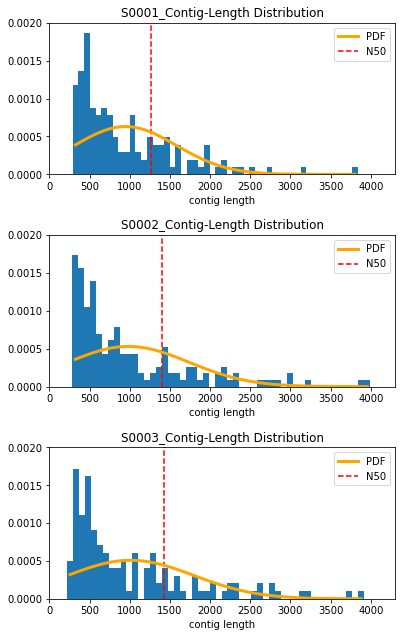

In [25]:
f, axs = plt.subplots(len(sample_dict), 1, figsize=(6, 10))

for i, df in enumerate(sample_dict):
    
    len_dist = sample_dict[df]['Seq_LEN']
    
    mu0, sigma0 = ss.norm.fit(len_dist)
   
    (values, bins0, _) = axs[i].hist(len_dist,bins=50,density=True) 
    bin_centers0 = 0.5*(bins0[1:] + bins0[:-1])
    pdf = ss.norm.pdf(x = bin_centers0, loc=mu0, scale=sigma0) #Compute probability density function

    N50_value = calculate_N50(list(len_dist))

    axs[i].plot(bin_centers0, pdf, label="PDF",color='orange',linewidth=3) #Plot PDF
    axs[i].vlines(N50_value,0,0.002, colors='red',linestyles='dashed',label='N50')
    axs[i].set_title(df+'_Contig-Length Distribution')
    axs[i].set(xlabel="contig length")
    axs[i].legend()
    axs[i].set_xlim(0,4300)
    axs[i].set_ylim(0,0.002)
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig(snakemake.output.len, dpi=300)

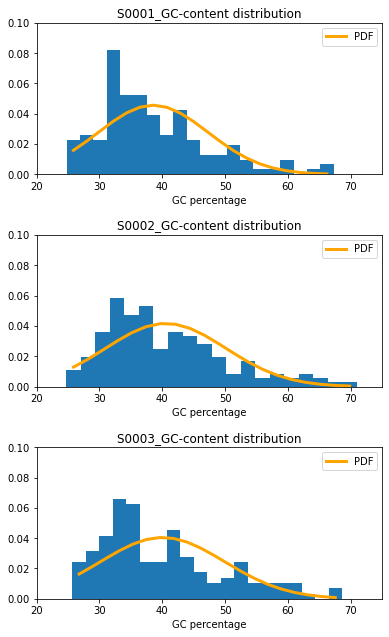

In [27]:
f, axs = plt.subplots(len(sample_dict), 1, figsize=(6, 10))

for i, df in enumerate(sample_dict):
    gc_dist = sample_dict[df]['GC_Content']
    mu1, sigma1 = ss.norm.fit(gc_dist)

    (values, bins1, _) = axs[i].hist(gc_dist, bins=20, density=True)
    bin_centers1 = 0.5*(bins1[1:] + bins1[:-1])
    pdf = ss.norm.pdf(x = bin_centers1, loc=mu1, scale=sigma1) 
    axs[i].plot(bin_centers1, pdf, label="PDF",color='orange',linewidth=3) 
    axs[i].legend()
    axs[i].set_title(df+'_GC-content distribution')
    axs[i].set(xlabel="GC percentage")
    axs[i].set_xlim(20,75)
    axs[i].set_ylim(0,0.1)
    
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.savefig(snakemake.output.gc, dpi=300, bbox_inches = 'tight')  